# Analyzing NYC High School Data

in this project we are going to explore clean and investigate correlations between Sat scores and demographics for New York high schools. we are going to use several data sets and combine them. all of data sets can be found in project directory.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.


## Reading the data sets

In this part we are going to read all .csv files and save all of them in a dictionary.

here is some information about these data sets:

SAT scores by school : SAT scores for each high school in New York City

School attendance : Attendance information for each school in New York City

Class size : Information on class size for each school

AP test results : Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

Graduation outcomes : The percentage of students who graduated, and other outcome information

Demographics : Demographic information for each school

School survey : Surveys of parents, teachers, and students at each school

In [1]:

import pandas as pd
import numpy as np
import re


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for file in data_files:
    data[file.replace(".csv", "")] = pd.read_csv("schools/" + file)

## Read in the survey files

there is two .txt file in data sets and their reading could be complicated, we are reading them using pd.read_csv method by passing delimiter="\t", encoding='windows-1252' as  arguments along with the file name as you can see in code blow then we combine them and change 'dbn' column name to "DBN" to make surveys same as other data sets in case of this important column name. DN is unique code for each school in New York city. for more information about the columns in surveys you can refer to zip file in [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8). there is a lot of columns in survey and we are going to just keep some of them which listed in the list_keep_columns list in blow

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter = "\t", encoding = "windows-1252")

d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter = "\t", encoding = "windows-1252")

survey = pd.concat([all_survey, d75_survey], axis = 0)

survey["DBN"] = survey["dbn"].copy()

list_keep_columns = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]


survey = survey[list_keep_columns]

data["survey"] = survey


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


## Add DBN columns

some of data sets like class_size and hs_directory do not have "DBN column. actually hs_directory does have dbn column we only need to rename it to DBN. The DBN is just a combination of the `CSD` and `SCHOOL CODE` columns in the class_size data. we only need extract the values in these columns and combine them to make DBN column in classs_size data.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(value):
    value = str(value)
    if len(value) < 2:
        return value.zfill(2)
    elif len(value) >= 2:
        return value
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric
in this part we just going to covert some columns to numerical values using to_numeric() function. also we extracted latitude and longitude of each school from `Location 1` column of hs_directory data and converted to numerical values and saved in hs_directory data as `lat` and `lon` columns 

In [4]:
num_columns = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in num_columns:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][num_columns[0]] + data['sat_results'][num_columns[1]] + data['sat_results'][num_columns[2]]

def latitude(string):
    cordinate = re.findall("\(.+\)", string)
    return cordinate[0].split(",")[0].replace("(", "")

def longitude(strig):
    cordinate = re.findall("\(.+\)", strig)
    return cordinate[0].split(",")[1].replace(")", "")

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(latitude)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(longitude)


data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors = "coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors = "coerce")

## Condense datasets

values in the DBN column are unique in the sat_results data set. Other data sets like class_size had duplicate DBN values, however. We'll need to condense these data sets so that each value in the DBN column is unique. 

lets look at some rows of class_size data set.


In [5]:
data['class_size'].head()


,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


As you can see in these few rows all rows is for just one school and it shows the DBN appears more than once. It looks like each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`. 

lets look at the unique values for `GRADE`

In [6]:
data['class_size']["GRADE "].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Because we're dealing with high schools, we keep grades 9 through 12.lets filter the data set and keep only those columns

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]

lets look at the unique values for P`ROGRAM TYPE`

In [8]:
data['class_size']["PROGRAM TYPE"].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

Each school can have multiple program types. Because GEN ED is the largest category, let's only select rows where PROGRAM TYPE is GEN ED

In [9]:
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

DBN still isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns.

In [10]:
data["class_size"]["CORE SUBJECT (MS CORE and 9-12 ONLY)"].unique()

array(['-', nan, 'ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'],
      dtype=object)

This column only seems to include certain subjects. we are going to take the average across all of the classes a school offers. This will give us unique DBN values. we are going to groupby class_size data based on `DBN` and calculate average of every column for every unique DBN then assign back to data set.

In [11]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

for demographics data set we are going to only keep rows with `schoolyear` of 20112012 which is the most recent year of data. also for graduation data we are going to keep rows with the most recent `Cohort` available, which is 2006 and only pick rows where `Demographic` is Total Cohort.

In [12]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric 
 in this part we are going to converts `AP Test Takers`, `Total Exams Taken`, `Number of Exams with scores 3 4 or 5` columns to numeric values from ap_2010 data

In [13]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

now it is the time to combine data sets into one data set. Both the `ap_2010` and the `graduation` data sets have many missing `DBN` values, so we'll use a `left` join when we merge the `sat_results` data set with them.

In [14]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

we are going to use inner merge for `class_size`, `demographics`, `survey`, and `hs_directory`. which all have fewer missing "DBN".

In [15]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

at last we are going to fill the rest of missing values with the mean value of corresponding column as in code blow

In [16]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

we will need to map the statistics based on school districts so we nee to add school district to our data set the first two characters of `DBN` column is actually is district number and we going to extract them and assign to our new `school_dist` column

In [17]:
combined["school_dist"] = combined["DBN"].apply(lambda string: string[0:2])

## Find correlations 

in this step we are going to calculate the correlation between sat score and other columns of data set as in blow

In [18]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

before we start plotting we are going to remove DBN from list_keep_columns  because it is just identifier not useful numerical value. for better understanding we saved the rest of list_keep_columns to survey_fields.

In [19]:
list_keep_columns.remove("DBN")
survey_fields = list_keep_columns

now lets plot a bar plot for correlations for only survey_fields

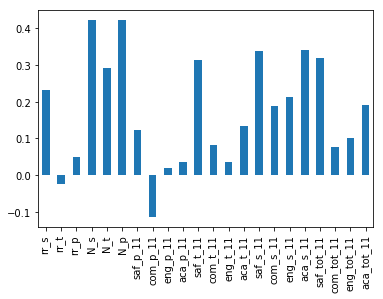

In [20]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

As you can see there is high correlation between sat score and N_s, N_p, and N_T. which are Number of student respondents, Number of parent respondents and Number of teacher respondents. it is obvious  because they or related to total enrollments.

Academic expectations based on teachers and parents responses (aca_t_11 and aca_p_11) correlation is low in compare to academic expectation based on student's responses (aca_s_11) which is very interesting thing.

Also students responses rate have high correlation (rr_s). That could be logical because the students who responded to survey and make time for these kind of things I think they have more interests and efforts to academics

Also there is a high correlation in saf_t_11 and saf_s_11 which indicates safety and respect score by teachers and students which is logical because in the unsafe environments it is really hard to teach and learn. 

lets go dig into this these columns more by making scatter plot for saf_s_11 column cs sat scores in combined.


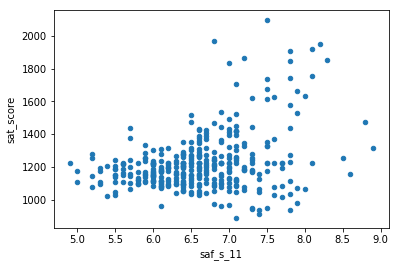

In [21]:
combined.plot.scatter(x = "saf_s_11", y = "sat_score")

there is a positive correlation between sat score and perceiving safety by students but it is not so strong. there are few very safe schools with very high scores and also few unsafe schools with very low sat score. in order to explore more we are going to map out this column by school district. we are using the base map of New York as in blow this code will create a map of New York and draws coastlines and rivers. we have the latitude and longitude of each school as numeric value in  combined["lat"] and  combined["lon"].

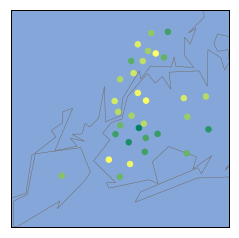

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

school_dist = combined.groupby("school_dist")

districts = school_dist.agg(np.mean)
districts.reset_index(inplace = True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()

latitudes = districts["lat"].tolist()

m.scatter(x = longitudes, y =latitudes, s = 30, zorder = 2,latlon = True, c = districts["saf_s_11"], cmap = "summer")

plt.show()


Upper Manhattan and parts of Queens and the Bronx  have higher safety scores in compare to  Brooklyn.

## Racial differences in SAT

lets explore racial differences in SAT scores.There are a few columns that indicate the percentage of each race at a given school:

`white_per`          
`asian_per`         
`black_per`          
`hispanic_per`           
lets plot a bar plot for each of these columns collation with sat score 

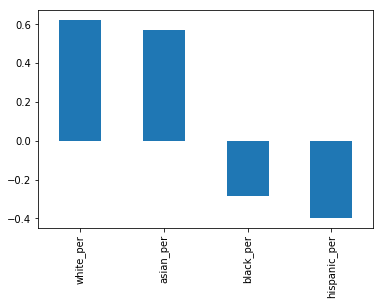

In [23]:
race_columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()["sat_score"][race_columns].plot.bar()

AS we can see there is a high positive correlation for white_per and asian_pers. also there is negative correlation between hispanic_per and sat score and I think this shows this exam is not really fair for different races.

lets plot scatter plot for hispanic_per vas sat_Score to investigate more

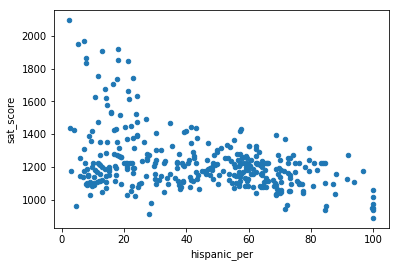

In [24]:
combined.plot.scatter("hispanic_per", "sat_score")

as we can see for schools with high percentage of hispanic the sat score is low actually for schools with more than 80 percent of hispanic_per the sat score is not higher than 1300. but we have schools with low percentage of hispanic_per but have a very low sat score. lets investigate schools hispanic_per greater than 95%. lets filter them in data set and find their names

In [25]:
hispanic_per_95 = combined[combined["hispanic_per"] > 95]
hispanic_per_95

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


These schools are mostly international schools which have a a lot of immigrant students who are learning English. This explain lower sat scores for these schools.

lets explore schools with a hispanic_per less than 10% and sat score greater than 1800

In [26]:
hispanic_per_10 = combined[(combined["hispanic_per"] < 95) & combined["sat_score"] < 1800]
hispanic_per_10

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


These schools mostly are in STEM and they have entrance exam and they have funding. this is nothing to do with hispanic_per. but it can explain high sat score wof these schools.


## Gender correlation

lets explore correlation for male_per and female_pr with sat_Score to see any relation

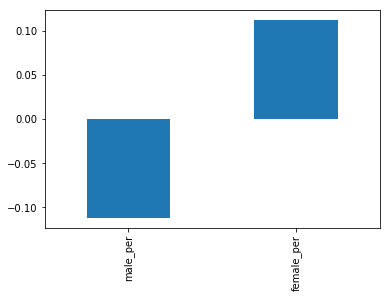

In [27]:
combined.corr()["sat_score"][["male_per", "female_per"]].plot.bar()

this bar plots shows us weak positive correlation for female percentage and weak negative correlation for male percentage. lets plot a scatter plot for female_per vs sat_score

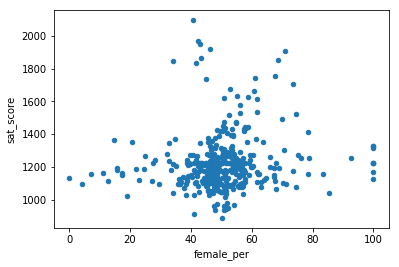

In [28]:
combined.plot.scatter("female_per", "sat_score")

again as you can see now in scatter plot there is no strong correlation between sat score and female_per. but schools with less then 30% of female and more than 80% of female do not have sat score more than 1400. lets plot scatter plot for male_per vs sat_Score

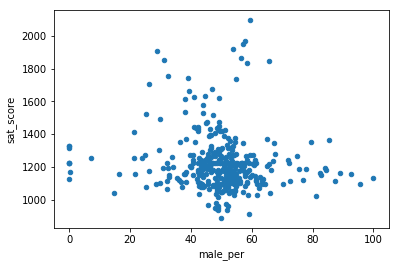

In [29]:
combined.plot.scatter("male_per", "sat_score")

it is somehow a same result but there is interesting thing here which shows the schools with somehow equal number of female and male students(some of them) have really high sat score but we can not imply that it happened only because of equality in number of female and male students but it did not happened at all in schools with non equality in number of female in male students.

lets explore schools with a female_per greater than 60% and an average SAT score greater than 1700.

In [30]:
female_60_sat_1700 = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
female_60_sat_1700

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


with a little search we can find out theses schools are very selective liberal arts schools that have high academic standards.

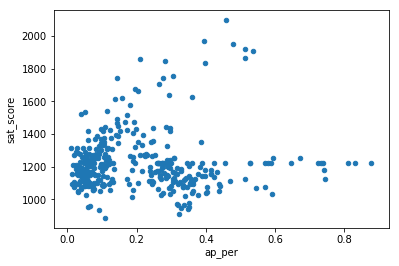

In [31]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")

There is no strong correlation. we can tell that schools with low percentage of students who took Advanced Placement (AP) exams mostly have low sat score but we can not tell strongly schools with high ap_per have high score. there are schools with high ap_per with high score but also there are some with low score.

## Conclusion 

we cleaned and combined different data set to analyse SAT score correlation for New York city high schools.here some of our results for correlation between different variables and sat scores:

1-Students responses rate have high correlation (rr_s). That could be logical because the students who responded to survey and make time for these kind of things they have more interests and efforts to academics

2- scores in safe environment are somehow high. in unsafe environment it is hard to learn or teach

3- Upper Manhattan and parts of Queens and the Bronx  have higher safety scores in compare to  Brooklyn.

4- Sat exam is not very fair for different races mostly for Hispanics and it need to more consideration

5- base on over scatter plots this exam is not unfair for genders hopefully 

6- We can tell (Not strongly) schools with low percentage of students who took Advanced Placement (AP) exams mostly have low sat score 
